In [38]:
import numpy as np
import pandas as pd
from functions import *
from schemes import *
from plot import * 

%matplotlib inline

In [39]:
# gravity
G = 1

# mass ratio & eccentricity 
q = 1.0 # q = m2 / m1
e = 0.6

m1 = 1 # central mass
m2 = q # orbiting mass
mu = G * (m1 + m2) 

# position
r1 = np.array([0,0.0,0.0], dtype="float64")
r2 = np.array([1,0.0,0.0], dtype="float64")

# velocity 
v1 = np.array([0,0.0,0], dtype="float64")
v2 = np.array([0,np.sqrt((1 + q)*(1 + e)),0], dtype="float64")

# create initial vectors
r0s = np.array([r1,r2])
v0s = np.array([v1,v2])
masses = np.array([m1, m2])


In [54]:
T = 100
h = 0.005

In [55]:
def SolveKepler(e, M):
    E0 = M
    while True:
        E1 = E0 - (E0 - e * np.sin(E0) - M) / (1 - e * np.cos(E0))
        if np.linalg.norm(E1 - E0) < 1e-8:
            return E1
        E0 = E1

def KeplerOrbit(a, e, mu, t):
    T = KeplerPeriod(a, mu)
    M = 2 * np.pi * t / T
    E = SolveKepler(e, M)
    theta = 2 * np.arctan2(np.sqrt(1 + e) * np.sin(E/2), np.sqrt(1 - e) * np.cos(E/2))
    r = a * (1 - e**2) / (1 + e * np.cos(theta))
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    z = np.zeros_like(x)
    return np.column_stack((x, y, z))

def SemiMajorAxis(mu, r0s, v0s):
    r = r0s[1, :]
    v = v0s[1, :]
    R = np.linalg.norm(r2)
    a = mu * R / (2 * mu - R * (v[0] ** 2 + v[1] ** 2))
    return a

def KeplerPeriod(a, mu): return 2 * np.pi * np.sqrt(a**3 / mu)

def AbsoluteError(scheme, r0s, v0s, T, h, G, m1, m2):
    mu = G * (m1 + m2) 
    
    # reposition centre of mass to origin with no momentum 
    rcom, vcom = CentreOfMass(r0s, v0s, masses)
    r0sprime = r0s - rcom
    v0sprime = v0s - vcom

    traj = run_scheme(scheme, 0, T, h, r0sprime, v0sprime, G, masses)
    
    a = SemiMajorAxis(mu, r0s, v0s)
    
    t_traj = np.array(traj[0]) 
    rs_traj = traj[1]

    kepler_traj = KeplerOrbit(a, e, mu, t_traj)
    
    errs = kepler_traj - rs_traj[:,1,:]
    errs = np.linalg.norm(errs, axis = 1)

    return errs, traj, kepler_traj

In [56]:
schemes = [EulerStep, EulerCromerStep, LeapfrogStep, RK4Step, ForestRuthStep, PEFRLStep]
names = ['Explicit Euler', 'Symplectic Euler', 'Leapfrog', 'RK4', 'Forest-Ruth', 'PEFRL']

In [57]:
plots = []
for scheme in schemes: 
    plots.append(AbsoluteError(scheme, r0s, v0s, T, h, G, m1, m2))

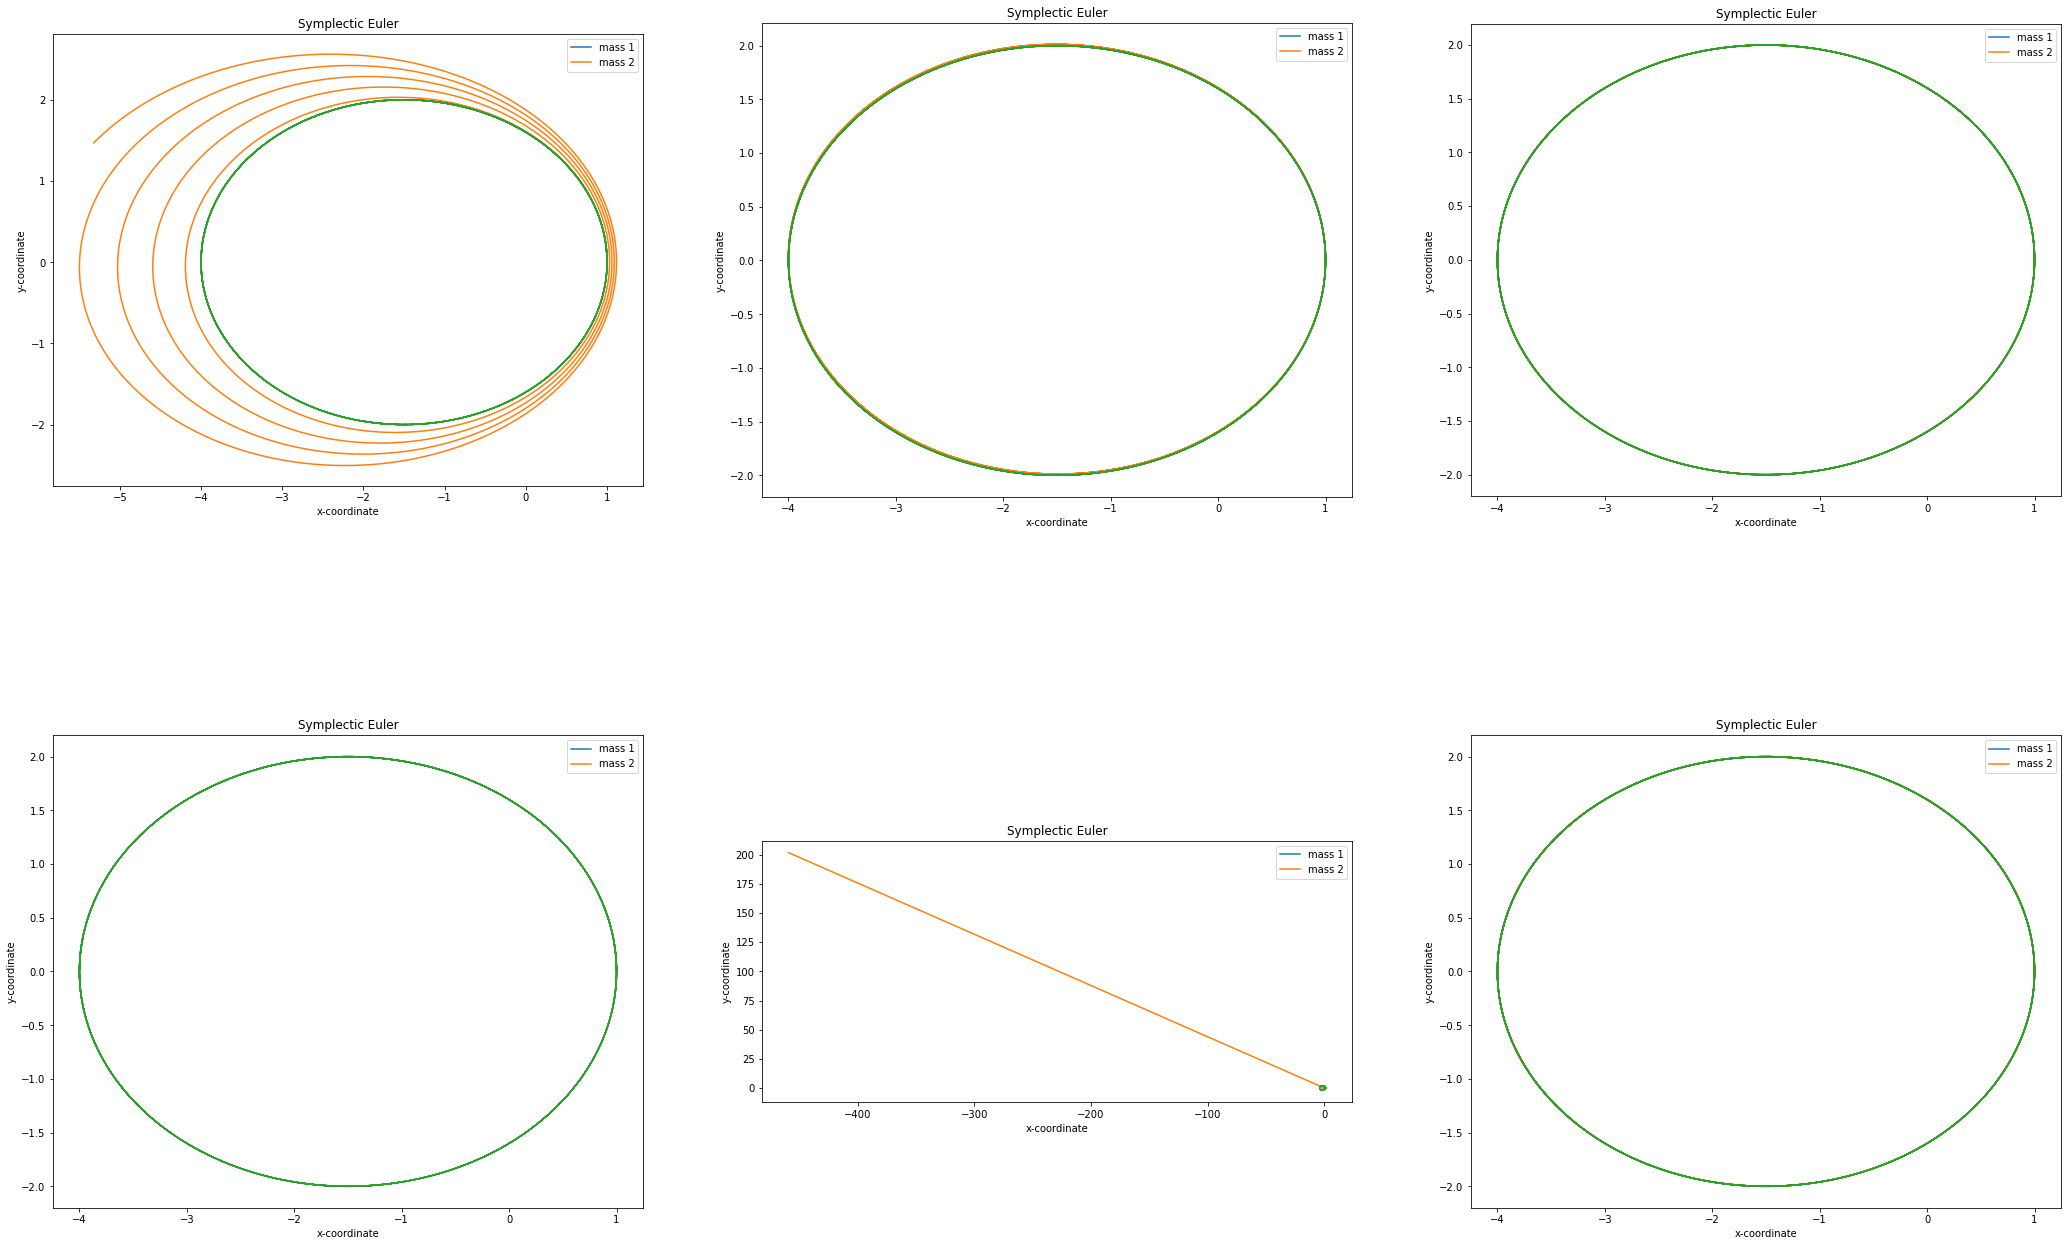

In [58]:
fig, axes = plt.subplots(2, 3, figsize = (36, 24))

axes = axes.flatten()

for i, ax in enumerate(axes):
    plot = plots[i]
    (errs, traj, kepler_traj) = plot
    rs_traj = traj[1]
    time = traj[-1]

    # loop over all masses 
    for i in range(2):
        ri_traj = rs_traj[:,i,:] # get the i-th trajectory
        ax.plot(ri_traj[:,0], ri_traj[:,1], label=f'mass {i+1}') # plot the orbits
        ax.scatter(ri_traj[0,0],ri_traj[0,1], marker="o", facecolors='none', s=50, zorder = 2) # plot the start p
        
    ax.plot(kepler_traj[:,0], kepler_traj[:,1], linestyle = '--')
    ax.set_aspect(aspect = 'equal')
    ax.set_title(f'{names[i]}')
    ax.set_xlabel('x-coordinate')
    ax.set_ylabel('y-coordinate')
    ax.legend()
    